In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.random import sample_without_replacement

----

In [2]:
def rgb2gray(img):
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140]).astype('uint8')

In [3]:
PATH = "img/"

----

In [11]:
'''
    Total Least Squares method (slide 08/70)
    ^ idea - distance between (x_i, y_i) and line (ax_i + by_i = d) with (a^2 + b^2 = 1)
             is |ax_i + by_i - d|
             
    - minimize the sum of squares
    
    @param X - (N,) array
    @param Y - (N,) array
'''
class TotalLeastSquares:
    def fit(self, X, y):
        X_mean = np.mean(X)
        y_mean = np.mean(y)
        
        # np.column_stack()
        U = np.stack([X - X_mean, y - y_mean], axis=-1)
        
        eigenvalues, eigenvectors = np.linalg.eig(U.T @ U)
        
        # select the eigenvector corresponding to the smallest eigenvalue
        pos = np.argmin(eigenvalues)
        a, b = eigenvectors[:, pos]
        
        d = a * X_mean + b * y_mean
        if (b == 0):
            # vertical line
            # add a small value to be able to convert to
            # (y = mx + n)
            b = 1e-4
        
        return (a, b, d)

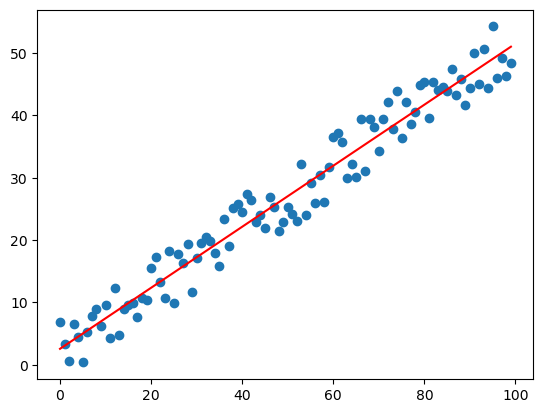

In [13]:
noise = np.random.uniform(-5, 5, 100)

xs = np.arange(100)
ys = .5 * xs + 2 + noise
plt.scatter(xs, ys)

tls = TotalLeastSquares()
a, b, d = tls.fit(xs, ys)

m, n = (-a/b), (d/b)
pred = [(m * x + n) for x in xs]

plt.plot(xs, pred, color='red')

----

## RANSAC

In [14]:
class RANSAC:
    def __init__(self, n_iters=2000, n_samples=2, dist_to_line=4):
        self.n_iters = n_iters
        
        self.n_samples = n_samples
        
        self.dist_to_line = dist_to_line
    
    def fit(self, X, y):
        N = X.shape[0]
        
        tls = TotalLeastSquares()
        
        max_inliers = 0
        res = None
        for _ in range(self.n_iters):
            idxs = sample_without_replacement(N, self.n_samples)
            
            X_samples = X[idxs]
            y_samples = y[idxs]
            
            a, b, d = tls.fit(X_samples, y_samples)\
            
            distances = np.abs(a * X + b * y - d)
            inliers = np.where(distances < self.dist_to_line)[0]
            
            X_inliers = X[inliers]
            y_inliers = y[inliers]
            
            if (len(inliers) > max_inliers):
                max_inliers = len(inliers)
                
                # refit only on the new inliers
                a, b, d = tls.fit(X_inliers, y_inliers)
                res = ((a, b, d), inliers, X_inliers, y_inliers)
        
        return res

91 inliers
(m, n) - (0.5134645886714578, 1.4335791085749903)


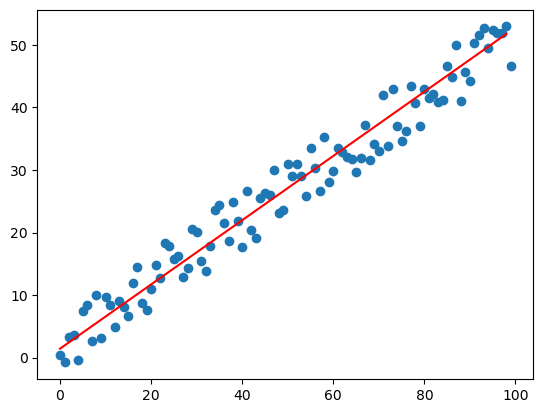

In [19]:
noise = np.random.uniform(-5, 5, 100)

xs = np.arange(100)
ys = .5 * xs + 2 + noise
plt.scatter(xs, ys)

model = RANSAC()
(a, b, d), inliers, X_inliers, y_inliers = model.fit(xs, ys)

print(f"{len(inliers)} inliers")

m, n = (-a/b), (d/b)
pred = [(m * x + n) for x in X_inliers]

print(f"(m, n) - ({m}, {n})")

plt.plot(X_inliers, pred, color='red')

- multiple lines - init test 

101 inliers
(m, n) - (0.4866432839282063, 2.0881011213190246)
89 inliers
(m, n) - (-0.5177553355915019, 2.3538766062325536)


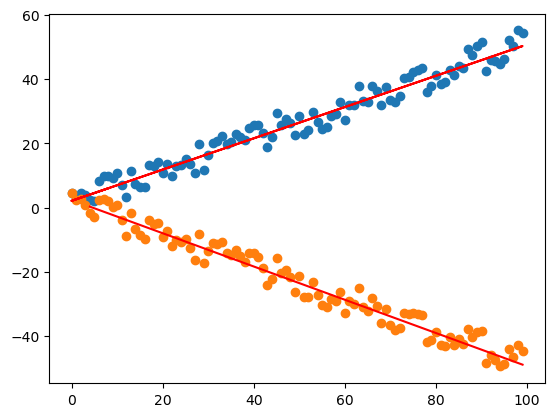

In [30]:
noise = np.random.uniform(-5, 5, 100)

xps = np.arange(100)
yps = .5 * xps + 2 + noise
plt.scatter(xps, yps)

xns = np.arange(100)
yns = -.5 * xns + 2 + noise
plt.scatter(xns, yns)

xs = np.concatenate([xps, xns], axis=0)
ys = np.concatenate([yps, yns], axis=0)

model = RANSAC()

## -- 1 --
(a, b, d), inliers, X_inliers, y_inliers = model.fit(xs, ys)

print(f"{len(inliers)} inliers")

m, n = (-a/b), (d/b)
pred = [(m * x + n) for x in X_inliers]

print(f"(m, n) - ({m}, {n})")

plt.plot(X_inliers, pred, color='red')

## --------------------

## -- 2 --
(a, b, d), inliers, X_inliers, y_inliers = model.fit(np.delete(xs, inliers), np.delete(ys, inliers))

print(f"{len(inliers)} inliers")

m, n = (-a/b), (d/b)
pred = [(m * x + n) for x in X_inliers]

print(f"(m, n) - ({m}, {n})")

plt.plot(X_inliers, pred, color='red')

## --------------------

----

In [33]:
def detect_lines(X, y, n_lines):
    model = RANSAC()
    
    Xc = deepcopy(X)
    yc = deepcopy(y)
    
    # each line - ((x0, y0), (x1, y1))
    lines = []
    for _ in range(n_lines):
        (a, b, d), inliers, X_inliers, y_inliers = model.fit(Xc, yc)
        
        m, n = (-a/b), (d/b)
        
        x0 = np.min(X_inliers)
        y0 = int(m * x0 + n) # need a pixel
        
        x1 = np.max(X_inliers)
        y1 = int(m * x1 + n)
        
        lines.append(((x0, y0), (x1, y1)))
        
        # remove the inliers for the next line
        Xc = np.delete(Xc, inliers)
        yc = np.delete(yc, inliers)
    
    return lines

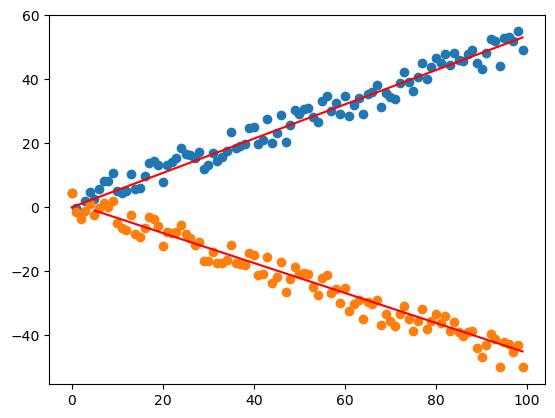

In [41]:
noise = np.random.uniform(-5, 5, 100)

xps = np.arange(100)
yps = .5 * xps + 2 + noise
plt.scatter(xps, yps)

xns = np.arange(100)
yns = -.5 * xns + 2 + noise
plt.scatter(xns, yns)

xs = np.concatenate([xps, xns], axis=0)
ys = np.concatenate([yps, yns], axis=0)

lines = detect_lines(xs, ys, 2)
for line in lines:
    (x0, y0), (x1, y1) = line
    plt.plot([x0, x1], [y0, y1], color='red')

----

(-0.5, 998.5, 490.5, -0.5)

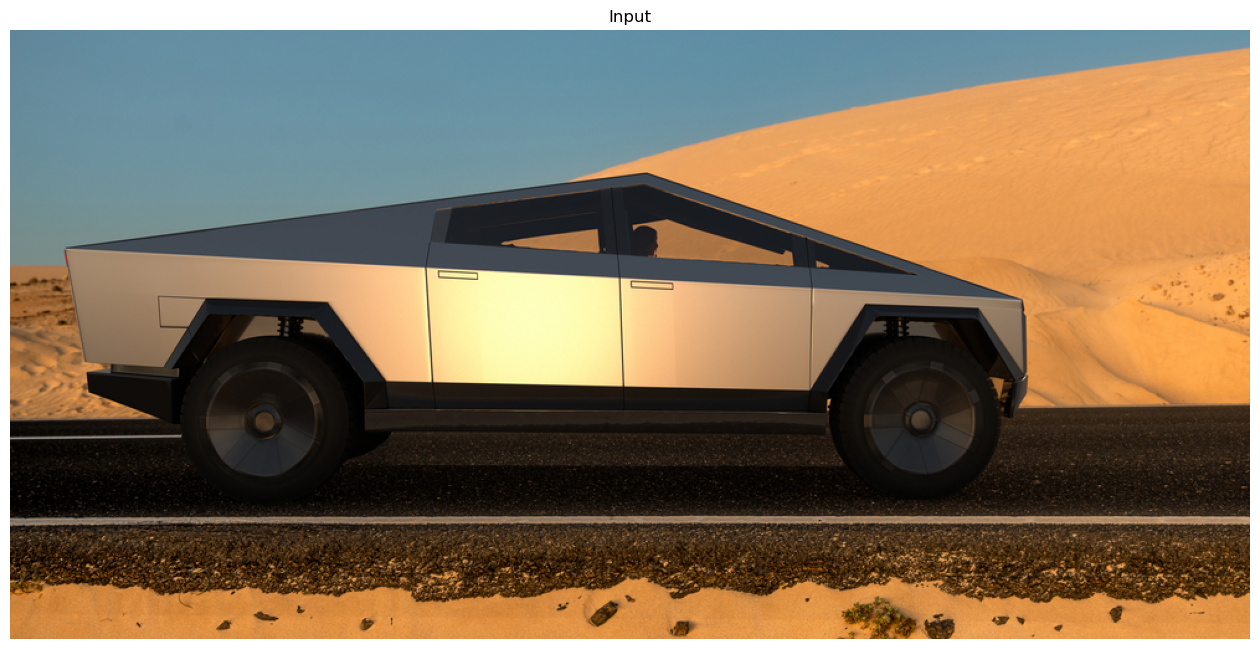

In [4]:
img = cv2.imread(PATH + "07.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, ax1 = plt.subplots(ncols=1, figsize=(16, 16))
ax1.set_title('Input')
ax1.imshow(img)
ax1.axis('off')

In [5]:
img.shape

(491, 999, 3)

(-0.5, 998.5, 490.5, -0.5)

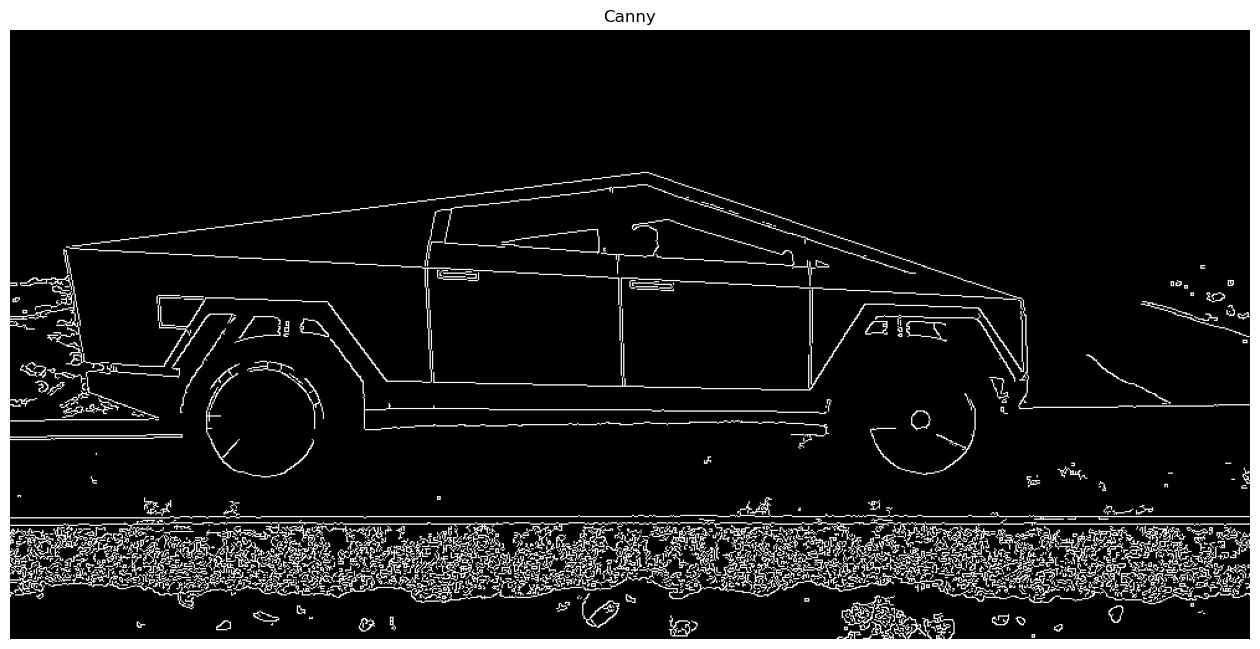

In [6]:
img_gray = img.copy()
img_gray = rgb2gray(img_gray)
img_gray = cv2.Canny(img_gray, threshold1=40, threshold2=250, apertureSize=3)

fig, ax1 = plt.subplots(ncols=1, figsize=(16, 16))
ax1.set_title('Canny')
ax1.imshow(img_gray, cmap='gray')
ax1.axis('off')

----

- translate into cartesian coordinates
  - y-axis only

In [42]:
y_white, X_white = np.where(img_gray == 255)
y_white = img.shape[0] - y_white # cartesian - flip the axis

y_white.shape, X_white.shape

((31739,), (31739,))

In [43]:
lines = detect_lines(X_white, y_white, 20)

(-0.5, 998.5, 490.5, -0.5)

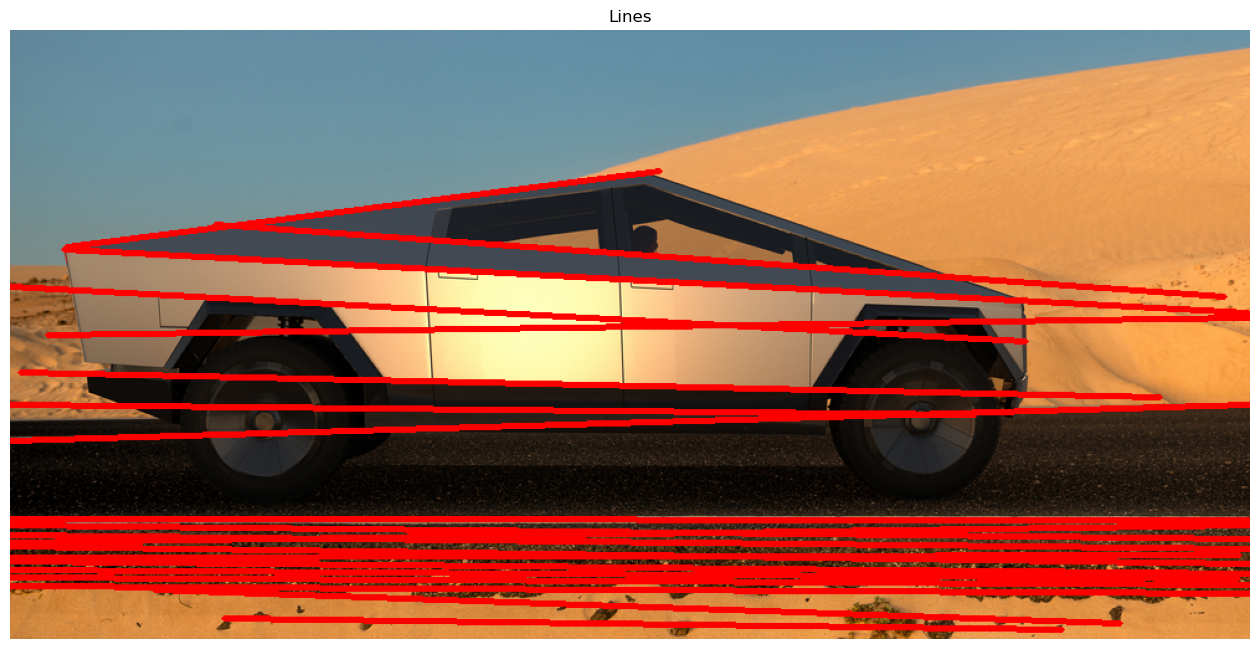

In [44]:
img_lines = deepcopy(img)

for line in lines:
    (x0, y0), (x1, y1) = line
    
    cv2.line(img_lines, (x0, img.shape[0] - y0),\
                        (x1, img.shape[0] - y1), (255, 0, 0), thickness=4)

fig, ax1 = plt.subplots(ncols=1, figsize=(16, 16))
ax1.set_title('Lines')
ax1.imshow(img_lines)
ax1.axis('off')

- noisy ground (as it can be seen from the Canny filter) - will result into many false lines

----